In [1]:
#####################
# IMPORT LIBS
#####################

import pandas as pd
import numpy as np
from pathlib import Path
import wandb
import datetime
import os
import random
import joblib
import shutil

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scoring import local_scorer
import scipy

from lightgbm import LGBMClassifier


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH 

TARGET_COLUMNS = ['sale_flg', 'sale_amount', 'contacts']
FIXED_SEEDS = [948, 534, 432, 597, 103, 21, 2242, 17, 20, 29]

RANDOM_SEED = 4444
USE_WANDB = False
CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

In [2]:
###############
# Config
###############

n_seed = 5
n_fold = 5
prediction_threshold = 0.2
retrain_after_valid = True
make_submission = False

In [3]:
if USE_WANDB:
    wandb.login()
    run = wandb.init(project="idao-2021-finals", name = f'{CURRENT_TIME}') # todo add config here

In [4]:
%%time

transactions = pd.read_csv(INPUT_PATH / 'trxn.csv')
assets_under_management = pd.read_csv(INPUT_PATH / 'aum.csv')
balance = pd.read_csv(INPUT_PATH / 'balance.csv')
client = pd.read_csv(INPUT_PATH / 'client.csv')
campaigns = pd.read_csv(INPUT_PATH / 'com.csv')
deals = pd.read_csv(INPUT_PATH / 'deals.csv')
dict_merchant_category_code = pd.read_csv(INPUT_PATH / 'dict_mcc.csv')
payments = pd.read_csv(INPUT_PATH / 'payments.csv')
funnel = pd.read_csv(INPUT_PATH / 'funnel.csv')
appl = pd.read_csv(INPUT_PATH / 'appl.csv')

In [5]:
payments = payments.sort_values(by='day_dt', ascending = False).reset_index(drop = True)

In [6]:
transactions['mcc_cd'] = transactions['mcc_cd'].fillna(-2)
transactions['txn_city'] = transactions['txn_city'].fillna('<UNK>')
transactions['tsp_name'] = transactions['tsp_name'].fillna('<UNK>')
transactions['txn_comment_2'] = transactions['txn_comment_2'].fillna('<UNK>')
transactions.merge(dict_merchant_category_code, on='mcc_cd', how='left')
transactions['brs_mcc_group'] = transactions['brs_mcc_group'].fillna('<UNK>')
transactions['brs_mcc_subgroup'] = transactions['brs_mcc_subgroup'].fillna('<UNK>')

balance['crncy_cd'] = balance['crncy_cd'].fillna(-2)
balance['prod_cat_name'] = balance['prod_cat_name'].fillna('<UNK>')
balance['prod_group_name'] = balance['prod_group_name'].fillna('<UNK>')

client = client.rename(columns={
    'gender': 'client_gender',
    'age': 'client_age',
    'region': 'client_region',
    'city': 'client_city',
    'citizenship': 'client_citizenship',
    'education': 'client_education',
    'job_type': 'client_job_type'
})

campaigns['prod'] = campaigns['prod'].fillna('<UNK>')

deals['crncy_cd'] = deals['crncy_cd'].fillna(-2)
deals['agrmnt_rate_active'] = deals['agrmnt_rate_active'].fillna(-2)
deals['agrmnt_rate_passive'] = deals['agrmnt_rate_passive'].fillna(-2)
deals['agrmnt_sum_rur'] = deals['agrmnt_sum_rur'].fillna(-2)
deals['prod_type_name'] = deals['prod_type_name'].fillna('<UNK>')
deals['argmnt_close_start_days'] = (pd.to_datetime(deals['agrmnt_close_dt']) - pd.to_datetime(deals['agrmnt_start_dt'])).dt.days.fillna(-2)

In [7]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [8]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     data[f'{feature_1} ** 2'] = data[feature_1] ** 2
#     data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
#     data[f'{feature_1} log'] = np.log(data[feature_1])

In [9]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [10]:
%%time
# create features

data = create_features_transactions(data)
data = create_features_aum(data)
data = create_features_balance(data)
data = create_features_client(data)
data = create_features_campaigns(data)
data = create_features_deals(data)
data = create_features_dict_mcc(data)
data = create_features_payments(data)
data = create_features_appl(data)
data = create_features_funnel(data)
data = create_features_deals(data)

In [11]:
def most_common(x, default='unknown'):
    try:
        # works faster then value_counts and pd.Series.mode
        return scipy.stats.mode(x)[0][0]
    except: 
        return default


def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_max(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].max()).fillna(fill_na_value)


def get_feature_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].min()).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)


def create_features_transactions(data):
    
    data = data.copy()
    
    # transaction features
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
    data['total_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = get_feature_mean(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    data['std_transaction_amount'] = get_feature_std(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    
    data['total_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_share_mcc_cd'] = (data['total_mcc_cd'] / data['total_transactions']).fillna(0)
    data['most_common_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_merchant_cd'] = (data['total_merchant_cd'] / data['total_transactions']).fillna(0)
    data['most_common_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_txn_city'] = (data['total_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_tsp_name'] = (data['total_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
    data['total_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
    data['most_common_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
    data['total_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
    data['most_common_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
    data['total_brs_mcc_group'] = get_feature_total(transactions, 'brs_mcc_group')
    data['most_common_brs_mcc_group'] = get_feature_most_common(transactions, 'brs_mcc_group', '<unknown>')
    
    data['total_brs_mcc_subgroup'] = get_feature_total(transactions, 'brs_mcc_subgroup')
    data['most_common_brs_mcc_subgroup'] = get_feature_most_common(transactions, 'brs_mcc_subgroup', '<unknown>')
    
    return data


def create_features_aum(data):
    data = data.copy()
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
    data['total_product_code'] = get_feature_total(assets_under_management, 'product_code')
    data['most_common_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_balance_rur_amt'] = get_feature_mean(assets_under_management, 'balance_rur_amt', -1)
    data['std_balance_rur_amt'] = get_feature_std(assets_under_management, 'balance_rur_amt', -1)
    data['max_min_balance_rur_amt'] = get_feature_max_min(assets_under_management, 'balance_rur_amt', -1)
    
    return data


def create_features_balance(data):
    data = data.copy()
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
    data['total_balance_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
    data['most_common_balance_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
    data['total_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_eop_bal_sum_rur'] = (data['total_eop_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_min_bal_sum_rur'] = (data['total_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_max_bal_sum_rur'] = (data['total_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_avg_bal_sum_rur'] = (data['total_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
    data['std_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
    data['total_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
    data['most_common_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
    data['most_common_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    return data


def create_features_client(data):
    data = data.copy()
    
    data = data.merge(client, on='client_id')
    data['match_client_region-region_cd'] = (data['client_region'] == data['region_cd']).astype(int)
    data.drop('client_citizenship', axis=1)
    
    return data


def create_features_campaigns(data):
    data = data.copy()
    
    data['total_campaigns'] = data['client_id'].map(campaigns.groupby('client_id').size()).fillna(0)
    
    data['total_agr_flg'] = get_feature_total(campaigns, 'agr_flg')
    data['mean_agr_flg'] = get_feature_mean(campaigns, 'agr_flg', -1)
    
    data['total_otkaz'] = get_feature_total(campaigns, 'otkaz')
    data['mean_otkaz'] = get_feature_mean(campaigns, 'otkaz', -1)
    
    data['total_dumaet'] = get_feature_total(campaigns, 'dumaet')
    data['mean_dumaet'] = get_feature_mean(campaigns, 'dumaet', -1)
    
    data['total_ring_up_flg'] = get_feature_total(campaigns, 'ring_up_flg')
    data['most_common_ring_up_flg'] = get_feature_most_common(campaigns, 'ring_up_flg', -1)
    
    data['total_count_comm'] = get_feature_total(campaigns, 'count_comm')
    data['most_common_count_comm'] = get_feature_most_common(campaigns, 'count_comm', -1)
    
    data['total_channel'] = get_feature_total(campaigns, 'channel')
    data['most_common_channel'] = get_feature_most_common(campaigns, 'channel', '<unknown>')
    
    data['total_prod'] = get_feature_total(campaigns, 'prod')
    data['most_common_prod'] = get_feature_most_common(campaigns, 'prod', '<unknown>')
    
    return data


def create_features_deals(data):
    data = data.copy()
    
    data['total_deals'] = data['client_id'].map(deals.groupby('client_id').size()).fillna(0)
    
    data['total_deals_crncy_cd'] = get_feature_total(deals, 'crncy_cd')
    data['most_common_deals_crncy_cd'] = get_feature_most_common(deals, 'crncy_cd', -1)
    
    data['total_agrmnt_rate_active'] = get_feature_total(deals, 'agrmnt_rate_active')
    data['max_agrmnt_rate_active'] = get_feature_max(deals, 'agrmnt_rate_active', -1)
    
    data['total_agrmnt_rate_passive'] = get_feature_total(deals, 'agrmnt_rate_passive')
    data['max_agrmnt_rate_passive'] = get_feature_max(deals, 'agrmnt_rate_passive', -1)
    
    data['total_agrmnt_sum_rur'] = get_feature_total(deals, 'agrmnt_sum_rur')
    data['mean_agrmnt_sum_rur'] = get_feature_mean(deals, 'agrmnt_sum_rur', -1)
    data['std_agrmnt_sum_rur'] = get_feature_std(deals, 'agrmnt_sum_rur', -1)
    
    data['total_prod_type_name'] = get_feature_total(deals, 'prod_type_name')
    data['most_common_prod_type_name'] = get_feature_most_common(deals, 'prod_type_name', '<unknown>')
    
    data['total_argmnt_close_start_days'] = get_feature_total(deals, 'argmnt_close_start_days')
    data['max_argmnt_close_start_days'] = get_feature_max(deals, 'argmnt_close_start_days', -1)
    data['min_argmnt_close_start_days'] = get_feature_min(deals, 'argmnt_close_start_days', -1)
    data['mean_argmnt_close_start_days'] = get_feature_mean(deals, 'argmnt_close_start_days', -1)
    data['std_argmnt_close_start_days'] = get_feature_std(deals, 'argmnt_close_start_days', -1)
    
    return data


def create_features_dict_mcc(data):
    data = data.copy()
    
    return data


def create_features_payments(data):
    data = data.copy()
    
    # payments 
    data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
    data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    return data


def create_features_appl(data):
    data = data.copy()
    
    return data


def create_features_funnel(data):
    data = data.copy()
    
    return data

In [12]:
%%time
# create features

data = create_features_transactions(data)
data = create_features_aum(data)
data = create_features_balance(data)
data = create_features_client(data)
data = create_features_campaigns(data)
data = create_features_deals(data)
data = create_features_dict_mcc(data)
data = create_features_payments(data)
data = create_features_appl(data)
data = create_features_funnel(data)
data = create_features_deals(data)

In [13]:
transactions['brs_mcc_group'] 

In [14]:
transactions

                   client_id              card_id            tran_time  \
0       -1893104556496814867 -6909844117230568380  2019-07-01 00:00:00   
1       -1893104556496814867 -6909844117230568380  2019-07-29 00:00:00   
2       -1893104556496814867 -6909844117230568380  2019-08-31 00:00:00   
3        6886062013213911831  6527755410945490683  2019-08-14 10:38:33   
4        6886062013213911831  6527755410945490683  2019-07-17 12:27:58   
...                      ...                  ...                  ...   
3035700 -3405096435133737788 -1484177776108621230  2018-09-06 07:41:17   
3035701  5941620754379828660 -4513708287312715087  2018-12-02 08:16:48   
3035702  5941620754379828660 -4513708287312715087  2018-12-28 13:55:12   
3035703  2964514409686635938  4497627322591857070  2018-12-21 09:32:26   
3035704 -6226831769412580676 -1272519220927585782  2018-10-30 08:11:24   

         tran_amt_rur  mcc_cd          merchant_cd txn_country     txn_city  \
0              6071.0  6011.0  3

In [15]:
transactions.merge(dict_merchant_category_code, on='mcc_cd', how='left')

                   client_id              card_id            tran_time  \
0       -1893104556496814867 -6909844117230568380  2019-07-01 00:00:00   
1       -1893104556496814867 -6909844117230568380  2019-07-29 00:00:00   
2       -1893104556496814867 -6909844117230568380  2019-08-31 00:00:00   
3        6886062013213911831  6527755410945490683  2019-08-14 10:38:33   
4        6886062013213911831  6527755410945490683  2019-07-17 12:27:58   
...                      ...                  ...                  ...   
3035700 -3405096435133737788 -1484177776108621230  2018-09-06 07:41:17   
3035701  5941620754379828660 -4513708287312715087  2018-12-02 08:16:48   
3035702  5941620754379828660 -4513708287312715087  2018-12-28 13:55:12   
3035703  2964514409686635938  4497627322591857070  2018-12-21 09:32:26   
3035704 -6226831769412580676 -1272519220927585782  2018-10-30 08:11:24   

         tran_amt_rur  mcc_cd          merchant_cd txn_country     txn_city  \
0              6071.0  6011.0  3

In [16]:
transactions['mcc_cd'] = transactions['mcc_cd'].fillna(-2)
transactions['txn_city'] = transactions['txn_city'].fillna('<UNK>')
transactions['tsp_name'] = transactions['tsp_name'].fillna('<UNK>')
transactions['txn_comment_2'] = transactions['txn_comment_2'].fillna('<UNK>')
transactions = transactions.merge(dict_merchant_category_code, on='mcc_cd', how='left')
transactions['brs_mcc_group'] = transactions['brs_mcc_group'].fillna('<UNK>')
transactions['brs_mcc_subgroup'] = transactions['brs_mcc_subgroup'].fillna('<UNK>')

balance['crncy_cd'] = balance['crncy_cd'].fillna(-2)
balance['prod_cat_name'] = balance['prod_cat_name'].fillna('<UNK>')
balance['prod_group_name'] = balance['prod_group_name'].fillna('<UNK>')

client = client.rename(columns={
    'gender': 'client_gender',
    'age': 'client_age',
    'region': 'client_region',
    'city': 'client_city',
    'citizenship': 'client_citizenship',
    'education': 'client_education',
    'job_type': 'client_job_type'
})

campaigns['prod'] = campaigns['prod'].fillna('<UNK>')

deals['crncy_cd'] = deals['crncy_cd'].fillna(-2)
deals['agrmnt_rate_active'] = deals['agrmnt_rate_active'].fillna(-2)
deals['agrmnt_rate_passive'] = deals['agrmnt_rate_passive'].fillna(-2)
deals['agrmnt_sum_rur'] = deals['agrmnt_sum_rur'].fillna(-2)
deals['prod_type_name'] = deals['prod_type_name'].fillna('<UNK>')
deals['argmnt_close_start_days'] = (pd.to_datetime(deals['agrmnt_close_dt']) - pd.to_datetime(deals['agrmnt_start_dt'])).dt.days.fillna(-2)

In [17]:
def most_common(x, default='unknown'):
    try:
        # works faster then value_counts and pd.Series.mode
        return scipy.stats.mode(x)[0][0]
    except: 
        return default


def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_max(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].max()).fillna(fill_na_value)


def get_feature_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].min()).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)


def create_features_transactions(data):
    
    data = data.copy()
    
    # transaction features
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
    data['total_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = get_feature_mean(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    data['std_transaction_amount'] = get_feature_std(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    
    data['total_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_share_mcc_cd'] = (data['total_mcc_cd'] / data['total_transactions']).fillna(0)
    data['most_common_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_merchant_cd'] = (data['total_merchant_cd'] / data['total_transactions']).fillna(0)
    data['most_common_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_txn_city'] = (data['total_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_tsp_name'] = (data['total_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
    data['total_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
    data['most_common_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
    data['total_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
    data['most_common_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
    data['total_brs_mcc_group'] = get_feature_total(transactions, 'brs_mcc_group')
    data['most_common_brs_mcc_group'] = get_feature_most_common(transactions, 'brs_mcc_group', '<unknown>')
    
    data['total_brs_mcc_subgroup'] = get_feature_total(transactions, 'brs_mcc_subgroup')
    data['most_common_brs_mcc_subgroup'] = get_feature_most_common(transactions, 'brs_mcc_subgroup', '<unknown>')
    
    return data


def create_features_aum(data):
    data = data.copy()
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
    data['total_product_code'] = get_feature_total(assets_under_management, 'product_code')
    data['most_common_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_balance_rur_amt'] = get_feature_mean(assets_under_management, 'balance_rur_amt', -1)
    data['std_balance_rur_amt'] = get_feature_std(assets_under_management, 'balance_rur_amt', -1)
    data['max_min_balance_rur_amt'] = get_feature_max_min(assets_under_management, 'balance_rur_amt', -1)
    
    return data


def create_features_balance(data):
    data = data.copy()
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
    data['total_balance_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
    data['most_common_balance_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
    data['total_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_eop_bal_sum_rur'] = (data['total_eop_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_min_bal_sum_rur'] = (data['total_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_max_bal_sum_rur'] = (data['total_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_avg_bal_sum_rur'] = (data['total_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
    data['std_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
    data['total_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
    data['most_common_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
    data['most_common_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    return data


def create_features_client(data):
    data = data.copy()
    
    data = data.merge(client, on='client_id')
    data['match_client_region-region_cd'] = (data['client_region'] == data['region_cd']).astype(int)
    data.drop('client_citizenship', axis=1)
    
    return data


def create_features_campaigns(data):
    data = data.copy()
    
    data['total_campaigns'] = data['client_id'].map(campaigns.groupby('client_id').size()).fillna(0)
    
    data['total_agr_flg'] = get_feature_total(campaigns, 'agr_flg')
    data['mean_agr_flg'] = get_feature_mean(campaigns, 'agr_flg', -1)
    
    data['total_otkaz'] = get_feature_total(campaigns, 'otkaz')
    data['mean_otkaz'] = get_feature_mean(campaigns, 'otkaz', -1)
    
    data['total_dumaet'] = get_feature_total(campaigns, 'dumaet')
    data['mean_dumaet'] = get_feature_mean(campaigns, 'dumaet', -1)
    
    data['total_ring_up_flg'] = get_feature_total(campaigns, 'ring_up_flg')
    data['most_common_ring_up_flg'] = get_feature_most_common(campaigns, 'ring_up_flg', -1)
    
    data['total_count_comm'] = get_feature_total(campaigns, 'count_comm')
    data['most_common_count_comm'] = get_feature_most_common(campaigns, 'count_comm', -1)
    
    data['total_channel'] = get_feature_total(campaigns, 'channel')
    data['most_common_channel'] = get_feature_most_common(campaigns, 'channel', '<unknown>')
    
    data['total_prod'] = get_feature_total(campaigns, 'prod')
    data['most_common_prod'] = get_feature_most_common(campaigns, 'prod', '<unknown>')
    
    return data


def create_features_deals(data):
    data = data.copy()
    
    data['total_deals'] = data['client_id'].map(deals.groupby('client_id').size()).fillna(0)
    
    data['total_deals_crncy_cd'] = get_feature_total(deals, 'crncy_cd')
    data['most_common_deals_crncy_cd'] = get_feature_most_common(deals, 'crncy_cd', -1)
    
    data['total_agrmnt_rate_active'] = get_feature_total(deals, 'agrmnt_rate_active')
    data['max_agrmnt_rate_active'] = get_feature_max(deals, 'agrmnt_rate_active', -1)
    
    data['total_agrmnt_rate_passive'] = get_feature_total(deals, 'agrmnt_rate_passive')
    data['max_agrmnt_rate_passive'] = get_feature_max(deals, 'agrmnt_rate_passive', -1)
    
    data['total_agrmnt_sum_rur'] = get_feature_total(deals, 'agrmnt_sum_rur')
    data['mean_agrmnt_sum_rur'] = get_feature_mean(deals, 'agrmnt_sum_rur', -1)
    data['std_agrmnt_sum_rur'] = get_feature_std(deals, 'agrmnt_sum_rur', -1)
    
    data['total_prod_type_name'] = get_feature_total(deals, 'prod_type_name')
    data['most_common_prod_type_name'] = get_feature_most_common(deals, 'prod_type_name', '<unknown>')
    
    data['total_argmnt_close_start_days'] = get_feature_total(deals, 'argmnt_close_start_days')
    data['max_argmnt_close_start_days'] = get_feature_max(deals, 'argmnt_close_start_days', -1)
    data['min_argmnt_close_start_days'] = get_feature_min(deals, 'argmnt_close_start_days', -1)
    data['mean_argmnt_close_start_days'] = get_feature_mean(deals, 'argmnt_close_start_days', -1)
    data['std_argmnt_close_start_days'] = get_feature_std(deals, 'argmnt_close_start_days', -1)
    
    return data


def create_features_dict_mcc(data):
    data = data.copy()
    
    return data


def create_features_payments(data):
    data = data.copy()
    
    # payments 
    data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
    data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    return data


def create_features_appl(data):
    data = data.copy()
    
    return data


def create_features_funnel(data):
    data = data.copy()
    
    return data

In [18]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [19]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     data[f'{feature_1} ** 2'] = data[feature_1] ** 2
#     data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
#     data[f'{feature_1} log'] = np.log(data[feature_1])

In [20]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [21]:
%%time
# create features

data = create_features_transactions(data)
data = create_features_aum(data)
data = create_features_balance(data)
data = create_features_client(data)
data = create_features_campaigns(data)
data = create_features_deals(data)
data = create_features_dict_mcc(data)
data = create_features_payments(data)
data = create_features_appl(data)
data = create_features_funnel(data)
data = create_features_deals(data)

In [22]:
def most_common(x, default='unknown'):
    try:
        # works faster then value_counts and pd.Series.mode
        return scipy.stats.mode(x)[0][0]
    except: 
        return default


def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_max(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].max()).fillna(fill_na_value)


def get_feature_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].min()).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)


def create_features_transactions(data):
    
    data = data.copy()
    
    # transaction features
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
    data['total_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = get_feature_mean(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    data['std_transaction_amount'] = get_feature_std(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    
    data['total_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_share_mcc_cd'] = (data['total_mcc_cd'] / data['total_transactions']).fillna(0)
    data['most_common_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_merchant_cd'] = (data['total_merchant_cd'] / data['total_transactions']).fillna(0)
    data['most_common_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_txn_city'] = (data['total_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_tsp_name'] = (data['total_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
    data['total_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
    data['most_common_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
    data['total_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
    data['most_common_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
    data['total_brs_mcc_group'] = get_feature_total(transactions, 'brs_mcc_group')
    data['most_common_brs_mcc_group'] = get_feature_most_common(transactions, 'brs_mcc_group', '<unknown>')
    
    data['total_brs_mcc_subgroup'] = get_feature_total(transactions, 'brs_mcc_subgroup')
    data['most_common_brs_mcc_subgroup'] = get_feature_most_common(transactions, 'brs_mcc_subgroup', '<unknown>')
    
    return data


def create_features_aum(data):
    data = data.copy()
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
    data['total_product_code'] = get_feature_total(assets_under_management, 'product_code')
    data['most_common_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_balance_rur_amt'] = get_feature_mean(assets_under_management, 'balance_rur_amt', -1)
    data['std_balance_rur_amt'] = get_feature_std(assets_under_management, 'balance_rur_amt', -1)
    data['max_min_balance_rur_amt'] = get_feature_max_min(assets_under_management, 'balance_rur_amt', -1)
    
    return data


def create_features_balance(data):
    data = data.copy()
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
    data['total_balance_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
    data['most_common_balance_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
    data['total_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_eop_bal_sum_rur'] = (data['total_eop_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_min_bal_sum_rur'] = (data['total_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_max_bal_sum_rur'] = (data['total_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_avg_bal_sum_rur'] = (data['total_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
    data['std_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
    data['total_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
    data['most_common_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
    data['most_common_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    return data


def create_features_client(data):
    data = data.copy()
    
#     data = data.merge(client, on='client_id')
    data['match_client_region-region_cd'] = (data['client_region'] == data['region_cd']).astype(int)
    data.drop('client_citizenship', axis=1)
    
    return data


def create_features_campaigns(data):
    data = data.copy()
    
    data['total_campaigns'] = data['client_id'].map(campaigns.groupby('client_id').size()).fillna(0)
    
    data['total_agr_flg'] = get_feature_total(campaigns, 'agr_flg')
    data['mean_agr_flg'] = get_feature_mean(campaigns, 'agr_flg', -1)
    
    data['total_otkaz'] = get_feature_total(campaigns, 'otkaz')
    data['mean_otkaz'] = get_feature_mean(campaigns, 'otkaz', -1)
    
    data['total_dumaet'] = get_feature_total(campaigns, 'dumaet')
    data['mean_dumaet'] = get_feature_mean(campaigns, 'dumaet', -1)
    
    data['total_ring_up_flg'] = get_feature_total(campaigns, 'ring_up_flg')
    data['most_common_ring_up_flg'] = get_feature_most_common(campaigns, 'ring_up_flg', -1)
    
    data['total_count_comm'] = get_feature_total(campaigns, 'count_comm')
    data['most_common_count_comm'] = get_feature_most_common(campaigns, 'count_comm', -1)
    
    data['total_channel'] = get_feature_total(campaigns, 'channel')
    data['most_common_channel'] = get_feature_most_common(campaigns, 'channel', '<unknown>')
    
    data['total_prod'] = get_feature_total(campaigns, 'prod')
    data['most_common_prod'] = get_feature_most_common(campaigns, 'prod', '<unknown>')
    
    return data


def create_features_deals(data):
    data = data.copy()
    
    data['total_deals'] = data['client_id'].map(deals.groupby('client_id').size()).fillna(0)
    
    data['total_deals_crncy_cd'] = get_feature_total(deals, 'crncy_cd')
    data['most_common_deals_crncy_cd'] = get_feature_most_common(deals, 'crncy_cd', -1)
    
    data['total_agrmnt_rate_active'] = get_feature_total(deals, 'agrmnt_rate_active')
    data['max_agrmnt_rate_active'] = get_feature_max(deals, 'agrmnt_rate_active', -1)
    
    data['total_agrmnt_rate_passive'] = get_feature_total(deals, 'agrmnt_rate_passive')
    data['max_agrmnt_rate_passive'] = get_feature_max(deals, 'agrmnt_rate_passive', -1)
    
    data['total_agrmnt_sum_rur'] = get_feature_total(deals, 'agrmnt_sum_rur')
    data['mean_agrmnt_sum_rur'] = get_feature_mean(deals, 'agrmnt_sum_rur', -1)
    data['std_agrmnt_sum_rur'] = get_feature_std(deals, 'agrmnt_sum_rur', -1)
    
    data['total_prod_type_name'] = get_feature_total(deals, 'prod_type_name')
    data['most_common_prod_type_name'] = get_feature_most_common(deals, 'prod_type_name', '<unknown>')
    
    data['total_argmnt_close_start_days'] = get_feature_total(deals, 'argmnt_close_start_days')
    data['max_argmnt_close_start_days'] = get_feature_max(deals, 'argmnt_close_start_days', -1)
    data['min_argmnt_close_start_days'] = get_feature_min(deals, 'argmnt_close_start_days', -1)
    data['mean_argmnt_close_start_days'] = get_feature_mean(deals, 'argmnt_close_start_days', -1)
    data['std_argmnt_close_start_days'] = get_feature_std(deals, 'argmnt_close_start_days', -1)
    
    return data


def create_features_dict_mcc(data):
    data = data.copy()
    
    return data


def create_features_payments(data):
    data = data.copy()
    
    # payments 
    data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
    data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    return data


def create_features_appl(data):
    data = data.copy()
    
    return data


def create_features_funnel(data):
    data = data.copy()
    
    return data

In [23]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
data = create_features_client(data)
data = create_features_campaigns(data)
data = create_features_deals(data)
data = create_features_dict_mcc(data)
data = create_features_payments(data)
data = create_features_appl(data)
data = create_features_funnel(data)
data = create_features_deals(data)

In [24]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [25]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [26]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [27]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [28]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [29]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [30]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [31]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [32]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [33]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [34]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [35]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [36]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > 0.18).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [37]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [38]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [39]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [40]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.13).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > 0.18).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [41]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [42]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [43]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [44]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [45]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [46]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [47]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [48]:
import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

In [49]:
feature_importance = pd.DataFrame(np.array([list(X.columns),model.feature_importances_]).T)
feature_importance.columns = ['column', 'importance']
feature_importance['importance'] = feature_importance['importance'].map(int)
feature_importance.sort_values(by='importance', ascending = False).iloc[:5, 0].values

array(['client_city', 'client_education', 'most_common_txn_city',
       'feature_9', 'feature_4'], dtype=object)

In [50]:
feature_importance = pd.DataFrame(np.array([list(X.columns),model.feature_importances_]).T)
feature_importance.columns = ['column', 'importance']
feature_importance['importance'] = feature_importance['importance'].map(int)
feature_importance.sort_values(by='importance', ascending = False).iloc[:25, 0].values

array(['client_city', 'client_education', 'most_common_txn_city',
       'feature_9', 'feature_4', 'feature_6', 'feature_1', 'client_age',
       'client_segment', 'last_known_salary',
       'most_common_prod_type_name', 'mean_balance_rur_amt', 'feature_2',
       'total_share_max_bal_sum_rur', 'feature_3', 'mean_agr_flg',
       'most_common_tsp_name', 'max_agrmnt_rate_active',
       'mean_min_bal_sum_rur', 'feature_7', 'total_campaigns',
       'feature_8', 'client_region', 'total_prod_group_name',
       'total_balance'], dtype=object)

In [51]:
X = X[['client_city', 'client_education', 'most_common_txn_city',
       'feature_9', 'feature_4', 'feature_6', 'feature_1', 'client_age',
       'client_segment', 'last_known_salary',
       'most_common_prod_type_name', 'mean_balance_rur_amt', 'feature_2',
       'total_share_max_bal_sum_rur', 'feature_3', 'mean_agr_flg',
       'most_common_tsp_name', 'max_agrmnt_rate_active',
       'mean_min_bal_sum_rur', 'feature_7', 'total_campaigns',
       'feature_8', 'client_region', 'total_prod_group_name',
       'total_balance']]

In [52]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [53]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [54]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [55]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [56]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [57]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [58]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [59]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [60]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [61]:
import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

In [62]:
feature_importance = pd.DataFrame(np.array([list(X.columns),model.feature_importances_]).T)
feature_importance.columns = ['column', 'importance']
feature_importance['importance'] = feature_importance['importance'].map(int)
feature_importance.sort_values(by='importance', ascending = False).iloc[:10, 0].values

array(['client_city', 'client_education', 'feature_9',
       'most_common_txn_city', 'feature_4', 'mean_min_bal_sum_rur',
       'total_share_max_bal_sum_rur', 'total_balance', 'client_segment',
       'feature_6'], dtype=object)

In [63]:
X = X[['client_city', 'client_education', 'feature_9',
       'most_common_txn_city', 'feature_4', 'mean_min_bal_sum_rur',
       'total_share_max_bal_sum_rur', 'total_balance', 'client_segment',
       'feature_6']]

In [64]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [65]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [66]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [67]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [68]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [69]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [70]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [71]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [72]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [73]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [74]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [75]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [76]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [77]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [78]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [79]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [80]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [81]:
feature_importance = pd.DataFrame(np.array([list(X.columns),model.feature_importances_]).T)
feature_importance.columns = ['column', 'importance']
feature_importance['importance'] = feature_importance['importance'].map(int)
feature_importance.sort_values(by='importance', ascending = False).iloc[:30, 0].values

array(['client_city', 'client_education', 'most_common_txn_city',
       'feature_9', 'feature_4', 'feature_6', 'feature_1', 'client_age',
       'client_segment', 'last_known_salary',
       'most_common_prod_type_name', 'mean_balance_rur_amt', 'feature_2',
       'total_share_max_bal_sum_rur', 'feature_3', 'mean_agr_flg',
       'most_common_tsp_name', 'max_agrmnt_rate_active',
       'mean_min_bal_sum_rur', 'feature_7', 'total_campaigns',
       'feature_8', 'client_region', 'total_prod_group_name',
       'total_balance', 'mean_otkaz', 'total_txn_city', 'feature_5',
       'total_share_tsp_name', 'mean_eop_bal_sum_rur'], dtype=object)

In [82]:
X = X[['client_city', 'client_education', 'most_common_txn_city',
       'feature_9', 'feature_4', 'feature_6', 'feature_1', 'client_age',
       'client_segment', 'last_known_salary',
       'most_common_prod_type_name', 'mean_balance_rur_amt', 'feature_2',
       'total_share_max_bal_sum_rur', 'feature_3', 'mean_agr_flg',
       'most_common_tsp_name', 'max_agrmnt_rate_active',
       'mean_min_bal_sum_rur', 'feature_7', 'total_campaigns',
       'feature_8', 'client_region', 'total_prod_group_name',
       'total_balance', 'mean_otkaz', 'total_txn_city', 'feature_5',
       'total_share_tsp_name', 'mean_eop_bal_sum_rur']]

In [83]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [84]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [85]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [86]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [87]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [88]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [89]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [90]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [91]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.18).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [92]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [93]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [94]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [95]:
appl

                 client_id month_end_dt appl_prod_group_name  \
0      6886062013213911831   2018-10-31                 PILS   
1      4497537671718296975   2018-10-31                 PILS   
2      1316154201527307743   2018-09-30                 PILS   
3      1316154201527307743   2018-09-30                 PILS   
4      1316154201527307743   2018-09-30                 PILS   
...                    ...          ...                  ...   
12025 -7051552770088413806   2019-03-31             Mortgage   
12026 -2283863549841851654   2019-02-28             Mortgage   
12027  4409001434092016310   2019-03-31             Mortgage   
12028 -2119157901008689776   2018-11-30                Cards   
12029 -1065664632342440074   2018-12-31                Cards   

      appl_prod_type_name         appl_stts_name_dc appl_sale_channel_name  
0                    PILS  The consultation is over                Network  
1                    PILS  The consultation is over                Network  


In [96]:
###############
# Config
###############

n_seed = 10
n_fold = 3
prediction_threshold = 0.2
retrain_after_valid = True
make_submission = False

In [97]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [98]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [99]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [100]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [101]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [102]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [103]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [104]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [105]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [106]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [107]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [108]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [109]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [110]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [111]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [112]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 128,
          "feature_fraction": feature_fraction,
          "drop_rate": 0.05,
          "is_unbalance": True,
          "max_drop": 20,
          "min_child_samples": 5,
          "min_child_weight": 50,
          "min_split_gain": 0,
          "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [113]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [114]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [115]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [116]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [117]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [118]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [119]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
          "boosting_type": "dart",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [120]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [121]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [122]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [123]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [124]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [125]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.18).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [126]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [127]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [128]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [129]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
          "boosting_type": "goss",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [130]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [131]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [132]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [133]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [134]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [135]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
          "learning_rate": 1e-3,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [136]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [137]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [138]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [139]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [140]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [141]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [142]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [143]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.5).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [144]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [145]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [146]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [147]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.1).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [148]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [149]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [150]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [151]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
          "learning_rate": 1e-1,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [152]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [153]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [154]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [155]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [156]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [157]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [158]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [159]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
          "learning_rate": 1e1,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [160]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [161]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [162]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [163]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [164]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [165]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
          "learning_rate": 3*1e-1,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [166]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [167]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [168]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [169]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [170]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [171]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [172]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [173]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [174]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [175]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
          "learning_rate":5 *1e-2,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [176]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [177]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [178]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [179]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [180]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [181]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
          "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [182]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [183]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [184]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [185]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [186]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [187]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.2)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [188]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [189]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [190]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [191]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.4)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [192]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [193]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [194]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [195]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.5)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [196]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [197]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [198]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [199]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [200]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [201]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [202]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [203]:
import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

In [204]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.1)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [205]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [206]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [207]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [208]:
target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.1)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [209]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [210]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [211]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [212]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [213]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [214]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [215]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [216]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.95)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [217]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [218]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [219]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [220]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.85)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [221]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [222]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [223]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [224]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [225]:
data['sale_flg'] = ((funnel['sale_flg'] * funnel['sale_amount'].fillna(0) - funnel['contacts'].fillna(0)*400/0.1) > -4000).astype(int)

In [226]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [227]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [228]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [229]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [230]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [231]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [232]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [233]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [234]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [235]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [236]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [237]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [238]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [239]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [240]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [241]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.1).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [242]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [243]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [244]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [245]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.3).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [246]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [247]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [248]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [249]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.4).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [250]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [251]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [252]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [253]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.25).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [254]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [255]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [256]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [257]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.15\).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [258]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.15).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [259]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [260]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [261]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [262]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.1).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [263]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [264]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [265]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [266]:
Y

0        0
1        0
2        0
3        0
4        1
        ..
21493    0
21494    0
21495    0
21496    1
21497    0
Name: sale_flg, Length: 21498, dtype: int64

In [267]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [268]:
data['sale_flg'] = (funnel['sale_flg'] * funnel['sale_amount'].fillna(0) - funnel['contacts'].fillna(0)*400/0.1)

In [269]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [270]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [271]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [272]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [273]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [274]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [275]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [276]:
Y

0         -4000.00
1         -4000.00
2         -4000.00
3         -4000.00
4        134018.05
           ...    
21493     -8000.00
21494     -4000.00
21495     -4000.00
21496     35882.85
21497     -4000.00
Name: sale_flg, Length: 21498, dtype: float64

In [277]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [278]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [279]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [280]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [281]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [282]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [283]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [284]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [285]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [286]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [287]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [288]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [289]:
np.mean(oof, axis = 1)

array([-4480.52101442, -4458.95793742, -4327.47530307, ...,
       -4483.28201999,  -581.27033875, -4836.61799501])

In [290]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > -400).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [291]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [292]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [293]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [294]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > -4000).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [295]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [296]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [297]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [298]:
np.mean(oof, axis = 1).max()

114859.59844903438

In [299]:
np.mean(oof, axis = 1).min()

-8065.480470430508

In [300]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > -6000).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [301]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [302]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [303]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [304]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > -5000).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [305]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [306]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [307]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [308]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > -4_500).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [309]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [310]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [311]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [312]:
#target_ = np.mean(oof, axis = 1)
#Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > -4_100).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [313]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [314]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [315]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [316]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.2)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [317]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [318]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [319]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [320]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.1)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [321]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [322]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [323]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [324]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.3)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [325]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [326]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [327]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [328]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.5)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [329]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [330]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [331]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [332]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.7)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [333]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [334]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [335]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [336]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.8)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [337]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [338]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [339]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [340]:
target_ = np.mean(oof, axis = 1)
Y_predicted = (target_ > np.quantile(target_, 0.7)).astype(int)
if n_fold != 1:
    #Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [341]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [342]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [343]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [344]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [345]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [346]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [347]:
data

                 client_id  sale_flg  sale_amount  contacts  feature_1  \
0      7513301859607023584         0          NaN         1          7   
1      9157009756404187626         0          NaN         1          3   
2     -1893104556496814867         0          NaN         1          5   
3      6886062013213911831         0          NaN         1          4   
4     -8156468515495593794         1    138018.05         1          7   
...                    ...       ...          ...       ...        ...   
21493  4662551505651924284         0          NaN         2          3   
21494 -8968737688687691353         0          NaN         1          9   
21495 -5799097497074119478         0          NaN         1          2   
21496 -2264802671063321355         1     43882.85         2          8   
21497  -174115151336149439         0          NaN         1          3   

       client_segment  feature_2  feature_3  feature_4  feature_5  ...  \
0                13.0   571533.0    1

In [348]:
data[[f'feature_{i}' for i in range(1, 11)]]

       feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0              7   571533.0    15717.0        0.0        0.0        0.0   
1              3  3642369.0    94787.0        0.0        0.0    84823.0   
2              5   352826.0     5500.0        0.0     6822.0        0.0   
3              4  6070615.0    40580.0        0.0    30401.0        0.0   
4              7  3642369.0    97156.0    81488.0        0.0   160308.0   
...          ...        ...        ...        ...        ...        ...   
21493          3  6070615.0    97616.0    21921.0    85635.0    89802.0   
21494          9  1821184.0     2428.0     3952.0        0.0    13938.0   
21495          2  6070615.0    64991.0        0.0    13450.0        0.0   
21496          8  2282408.0     5832.0    16185.0        0.0    82182.0   
21497          3  6070615.0  1014167.0        0.0  1053209.0        0.0   

       feature_7  feature_8  feature_9  feature_10  
0       571852.0   472605.0       10.4     125

In [349]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=6)
kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

array([0, 1, 0, ..., 4, 2, 4], dtype=int32)

In [350]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=6)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

In [351]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [352]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [353]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [354]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [355]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [356]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [357]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [358]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [359]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [360]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [361]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [362]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [363]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [364]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [365]:
data

                 client_id  sale_flg  sale_amount  contacts  feature_1  \
0      7513301859607023584         0          NaN         1          7   
1      9157009756404187626         0          NaN         1          3   
2     -1893104556496814867         0          NaN         1          5   
3      6886062013213911831         0          NaN         1          4   
4     -8156468515495593794         1    138018.05         1          7   
...                    ...       ...          ...       ...        ...   
21493  4662551505651924284         0          NaN         2          3   
21494 -8968737688687691353         0          NaN         1          9   
21495 -5799097497074119478         0          NaN         1          2   
21496 -2264802671063321355         1     43882.85         2          8   
21497  -174115151336149439         0          NaN         1          3   

       client_segment  feature_2  feature_3  feature_4  feature_5  ...  \
0                13.0   571533.0    1

In [366]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [367]:
data

                 client_id  sale_flg  sale_amount  contacts  feature_1  \
0      7513301859607023584         0          NaN         1          7   
1      9157009756404187626         0          NaN         1          3   
2     -1893104556496814867         0          NaN         1          5   
3      6886062013213911831         0          NaN         1          4   
4     -8156468515495593794         1    138018.05         1          7   
...                    ...       ...          ...       ...        ...   
21493  4662551505651924284         0          NaN         2          3   
21494 -8968737688687691353         0          NaN         1          9   
21495 -5799097497074119478         0          NaN         1          2   
21496 -2264802671063321355         1     43882.85         2          8   
21497  -174115151336149439         0          NaN         1          3   

       client_segment  feature_2  feature_3  feature_4  feature_5  ...  \
0                13.0   571533.0    1

In [368]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=10)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

In [369]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [370]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [371]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [372]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [373]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [374]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [375]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [376]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [377]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [378]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [379]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [380]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [381]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [382]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [383]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [384]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [385]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [386]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [387]:
import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

In [388]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

In [389]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [390]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [391]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [392]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [393]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [394]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [395]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [396]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [397]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [398]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [399]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [400]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [401]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [402]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [403]:
import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

In [404]:
###############
# Config
###############

n_seed = 3
n_fold = 3
prediction_threshold = 0.2
retrain_after_valid = True
make_submission = False

In [405]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [406]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [407]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

In [408]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [409]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [410]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [411]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [412]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [413]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [414]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [415]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [416]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [417]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [418]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [419]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [420]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [421]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [422]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [423]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [424]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

joblib.dump(model, OUTPUT_PATH / 'kmeans' / f'kmeans.pkl')

In [425]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

joblib.dump(kmeans, OUTPUT_PATH / 'kmeans' / f'kmeans.pkl')

In [426]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

joblib.dump(kmeans, OUTPUT_PATH / 'cluster' / f'kmeans.pkl')

['../output/cluster/kmeans.pkl']

In [427]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [428]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [429]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [430]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [431]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [432]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [433]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [434]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [435]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [436]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [437]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [438]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [439]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [440]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [441]:
###############
# Config
###############

n_seed = 10
n_fold = 3
prediction_threshold = 0.2
retrain_after_valid = True
make_submission = False

In [442]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [443]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [444]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

joblib.dump(kmeans, OUTPUT_PATH / 'cluster' / f'kmeans.pkl')

['../output/cluster/kmeans.pkl']

In [445]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [446]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [447]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [448]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [449]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [450]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [451]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [452]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [453]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [454]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [455]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [456]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [457]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [458]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [459]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [460]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [461]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [462]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [463]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [464]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [465]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [466]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.1).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [467]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [468]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [469]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [470]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.25).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [471]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [472]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [473]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [474]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.4).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [475]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [476]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [477]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [478]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [479]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [480]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

joblib.dump(kmeans, OUTPUT_PATH / 'cluster' / f'kmeans.pkl')

['../output/cluster/kmeans.pkl']

In [481]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [482]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [483]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [484]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [485]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [486]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [487]:
data

                 client_id  sale_flg  sale_amount  contacts  feature_1  \
0      7513301859607023584         0          NaN         1          7   
1      9157009756404187626         0          NaN         1          3   
2     -1893104556496814867         0          NaN         1          5   
3      6886062013213911831         0          NaN         1          4   
4     -8156468515495593794         1    138018.05         1          7   
...                    ...       ...          ...       ...        ...   
21493  4662551505651924284         0          NaN         2          3   
21494 -8968737688687691353         0          NaN         1          9   
21495 -5799097497074119478         0          NaN         1          2   
21496 -2264802671063321355         1     43882.85         2          8   
21497  -174115151336149439         0          NaN         1          3   

       client_segment  feature_2  feature_3  feature_4  feature_5  ...  \
0                13.0   571533.0    1

In [488]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [489]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [490]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [491]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [492]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [493]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [494]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [495]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [496]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.15).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [497]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [498]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [499]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [500]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.1).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [501]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [502]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [503]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [504]:
oof

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [505]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]
        #prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [506]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.1).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [507]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [508]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [509]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [510]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.2).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [511]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [512]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [513]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [514]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.15).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [515]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [516]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [517]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [518]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.1).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [519]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [520]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [521]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [522]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [523]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [524]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [525]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [526]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [527]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [528]:
#####################
# IMPORT LIBS
#####################

import pandas as pd
import numpy as np
from pathlib import Path
import wandb
import datetime
import os
import random
import joblib
import shutil

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scoring import local_scorer
import scipy

from lightgbm import LGBMClassifier


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH 

TARGET_COLUMNS = ['sale_flg', 'sale_amount', 'contacts']
FIXED_SEEDS = [948, 534, 432, 597, 103, 21, 2242, 17, 20, 29]

RANDOM_SEED = 4444
USE_WANDB = True
CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

In [529]:
###############
# Config
###############

n_seed = 10
n_fold = 3
prediction_threshold = 0.2
retrain_after_valid = True
make_submission = False

In [530]:
if USE_WANDB:
    wandb.login()
    run = wandb.init(project="idao-2021-finals", name = f'{CURRENT_TIME}') # todo add config here

In [531]:
%%time

transactions = pd.read_csv(INPUT_PATH / 'trxn.csv')
assets_under_management = pd.read_csv(INPUT_PATH / 'aum.csv')
balance = pd.read_csv(INPUT_PATH / 'balance.csv')
client = pd.read_csv(INPUT_PATH / 'client.csv')
campaigns = pd.read_csv(INPUT_PATH / 'com.csv')
deals = pd.read_csv(INPUT_PATH / 'deals.csv')
dict_merchant_category_code = pd.read_csv(INPUT_PATH / 'dict_mcc.csv')
payments = pd.read_csv(INPUT_PATH / 'payments.csv')
funnel = pd.read_csv(INPUT_PATH / 'funnel.csv')
appl = pd.read_csv(INPUT_PATH / 'appl.csv')

In [532]:
payments = payments.sort_values(by='day_dt', ascending = False).reset_index(drop = True)

In [533]:
transactions['mcc_cd'] = transactions['mcc_cd'].fillna(-2)
transactions['txn_city'] = transactions['txn_city'].fillna('<UNK>')
transactions['tsp_name'] = transactions['tsp_name'].fillna('<UNK>')
transactions['txn_comment_2'] = transactions['txn_comment_2'].fillna('<UNK>')
transactions = transactions.merge(dict_merchant_category_code, on='mcc_cd', how='left')
transactions['brs_mcc_group'] = transactions['brs_mcc_group'].fillna('<UNK>')
transactions['brs_mcc_subgroup'] = transactions['brs_mcc_subgroup'].fillna('<UNK>')

balance['crncy_cd'] = balance['crncy_cd'].fillna(-2)
balance['prod_cat_name'] = balance['prod_cat_name'].fillna('<UNK>')
balance['prod_group_name'] = balance['prod_group_name'].fillna('<UNK>')

client = client.rename(columns={
    'gender': 'client_gender',
    'age': 'client_age',
    'region': 'client_region',
    'city': 'client_city',
    'citizenship': 'client_citizenship',
    'education': 'client_education',
    'job_type': 'client_job_type'
})

campaigns['prod'] = campaigns['prod'].fillna('<UNK>')

deals['crncy_cd'] = deals['crncy_cd'].fillna(-2)
deals['agrmnt_rate_active'] = deals['agrmnt_rate_active'].fillna(-2)
deals['agrmnt_rate_passive'] = deals['agrmnt_rate_passive'].fillna(-2)
deals['agrmnt_sum_rur'] = deals['agrmnt_sum_rur'].fillna(-2)
deals['prod_type_name'] = deals['prod_type_name'].fillna('<UNK>')
deals['argmnt_close_start_days'] = (pd.to_datetime(deals['agrmnt_close_dt']) - pd.to_datetime(deals['agrmnt_start_dt'])).dt.days.fillna(-2)

In [534]:
def most_common(x, default='unknown'):
    try:
        # works faster then value_counts and pd.Series.mode
        return scipy.stats.mode(x)[0][0]
    except: 
        return default


def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_max(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].max()).fillna(fill_na_value)


def get_feature_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].min()).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)


def create_features_transactions(data):
    
    data = data.copy()
    
    # transaction features
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
    data['total_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = get_feature_mean(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    data['std_transaction_amount'] = get_feature_std(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    
    data['total_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_share_mcc_cd'] = (data['total_mcc_cd'] / data['total_transactions']).fillna(0)
    data['most_common_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_merchant_cd'] = (data['total_merchant_cd'] / data['total_transactions']).fillna(0)
    data['most_common_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_txn_city'] = (data['total_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_tsp_name'] = (data['total_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
    data['total_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
    data['most_common_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
    data['total_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
    data['most_common_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
    data['total_brs_mcc_group'] = get_feature_total(transactions, 'brs_mcc_group')
    data['most_common_brs_mcc_group'] = get_feature_most_common(transactions, 'brs_mcc_group', '<unknown>')
    
    data['total_brs_mcc_subgroup'] = get_feature_total(transactions, 'brs_mcc_subgroup')
    data['most_common_brs_mcc_subgroup'] = get_feature_most_common(transactions, 'brs_mcc_subgroup', '<unknown>')
    
    return data


def create_features_aum(data):
    data = data.copy()
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
    data['total_product_code'] = get_feature_total(assets_under_management, 'product_code')
    data['most_common_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_balance_rur_amt'] = get_feature_mean(assets_under_management, 'balance_rur_amt', -1)
    data['std_balance_rur_amt'] = get_feature_std(assets_under_management, 'balance_rur_amt', -1)
    data['max_min_balance_rur_amt'] = get_feature_max_min(assets_under_management, 'balance_rur_amt', -1)
    
    return data


def create_features_balance(data):
    data = data.copy()
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
    data['total_balance_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
    data['most_common_balance_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
    data['total_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_eop_bal_sum_rur'] = (data['total_eop_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_min_bal_sum_rur'] = (data['total_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_max_bal_sum_rur'] = (data['total_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_avg_bal_sum_rur'] = (data['total_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
    data['std_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
    data['total_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
    data['most_common_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
    data['most_common_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    return data


def create_features_client(data):
    data = data.copy()
    
#     data = data.merge(client, on='client_id')
    data['match_client_region-region_cd'] = (data['client_region'] == data['region_cd']).astype(int)
    data.drop('client_citizenship', axis=1)
    
    return data


def create_features_campaigns(data):
    data = data.copy()
    
    data['total_campaigns'] = data['client_id'].map(campaigns.groupby('client_id').size()).fillna(0)
    
    data['total_agr_flg'] = get_feature_total(campaigns, 'agr_flg')
    data['mean_agr_flg'] = get_feature_mean(campaigns, 'agr_flg', -1)
    
    data['total_otkaz'] = get_feature_total(campaigns, 'otkaz')
    data['mean_otkaz'] = get_feature_mean(campaigns, 'otkaz', -1)
    
    data['total_dumaet'] = get_feature_total(campaigns, 'dumaet')
    data['mean_dumaet'] = get_feature_mean(campaigns, 'dumaet', -1)
    
    data['total_ring_up_flg'] = get_feature_total(campaigns, 'ring_up_flg')
    data['most_common_ring_up_flg'] = get_feature_most_common(campaigns, 'ring_up_flg', -1)
    
    data['total_count_comm'] = get_feature_total(campaigns, 'count_comm')
    data['most_common_count_comm'] = get_feature_most_common(campaigns, 'count_comm', -1)
    
    data['total_channel'] = get_feature_total(campaigns, 'channel')
    data['most_common_channel'] = get_feature_most_common(campaigns, 'channel', '<unknown>')
    
    data['total_prod'] = get_feature_total(campaigns, 'prod')
    data['most_common_prod'] = get_feature_most_common(campaigns, 'prod', '<unknown>')
    
    return data


def create_features_deals(data):
    data = data.copy()
    
    data['total_deals'] = data['client_id'].map(deals.groupby('client_id').size()).fillna(0)
    
    data['total_deals_crncy_cd'] = get_feature_total(deals, 'crncy_cd')
    data['most_common_deals_crncy_cd'] = get_feature_most_common(deals, 'crncy_cd', -1)
    
    data['total_agrmnt_rate_active'] = get_feature_total(deals, 'agrmnt_rate_active')
    data['max_agrmnt_rate_active'] = get_feature_max(deals, 'agrmnt_rate_active', -1)
    
    data['total_agrmnt_rate_passive'] = get_feature_total(deals, 'agrmnt_rate_passive')
    data['max_agrmnt_rate_passive'] = get_feature_max(deals, 'agrmnt_rate_passive', -1)
    
    data['total_agrmnt_sum_rur'] = get_feature_total(deals, 'agrmnt_sum_rur')
    data['mean_agrmnt_sum_rur'] = get_feature_mean(deals, 'agrmnt_sum_rur', -1)
    data['std_agrmnt_sum_rur'] = get_feature_std(deals, 'agrmnt_sum_rur', -1)
    
    data['total_prod_type_name'] = get_feature_total(deals, 'prod_type_name')
    data['most_common_prod_type_name'] = get_feature_most_common(deals, 'prod_type_name', '<unknown>')
    
    data['total_argmnt_close_start_days'] = get_feature_total(deals, 'argmnt_close_start_days')
    data['max_argmnt_close_start_days'] = get_feature_max(deals, 'argmnt_close_start_days', -1)
    data['min_argmnt_close_start_days'] = get_feature_min(deals, 'argmnt_close_start_days', -1)
    data['mean_argmnt_close_start_days'] = get_feature_mean(deals, 'argmnt_close_start_days', -1)
    data['std_argmnt_close_start_days'] = get_feature_std(deals, 'argmnt_close_start_days', -1)
    
    return data


def create_features_dict_mcc(data):
    data = data.copy()
    
    return data


def create_features_payments(data):
    data = data.copy()
    
    # payments 
    data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
    data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    return data


def create_features_appl(data):
    data = data.copy()
    
    return data


def create_features_funnel(data):
    data = data.copy()
    
    return data

In [535]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [536]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [537]:
from sklearn.cluster import KMeans
# Create cluster feature
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[[f'feature_{i}' for i in range(1, 11)]].fillna(0))

joblib.dump(kmeans, OUTPUT_PATH / 'cluster' / f'kmeans.pkl')

['../output/cluster/kmeans.pkl']

In [538]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [539]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_deals(data)
# data = create_features_dict_mcc(data)
# data = create_features_payments(data)
# data = create_features_appl(data)
# data = create_features_funnel(data)
# data = create_features_deals(data)

In [540]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [541]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [542]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [543]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [544]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [545]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [546]:
from lightgbm import LGBMRegressor
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMRegressor(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [547]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        #prediction = model.predict_proba(X_val)[:, 1]
        prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [548]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [549]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [550]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [551]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [552]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [553]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [554]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [555]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [556]:
import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

array(['client_city', 'feature_4', 'feature_6', 'feature_5', 'feature_9',
       'client_age', 'feature_3', 'client_segment', 'client_education',
       'client_region', 'region_cd', 'feature_2', 'feature_8',
       'feature_1', 'feature_7', 'feature_10', 'feature_4 log',
       'client_gender', 'feature_3 log', 'feature_6 log', 'feature_5 log',
       'cluster', 'feature_2 ** 2', 'feature_2 ** 0.5', 'feature_10 log',
       'feature_10 ** 0.5', 'feature_10 ** 2', 'feature_9 log',
       'feature_9 ** 0.5', 'feature_9 ** 2'], dtype=object)

<Figure size 2160x2160 with 0 Axes>

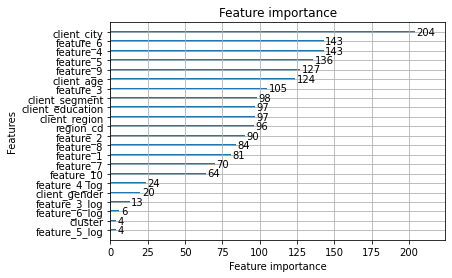

In [557]:
feature_importance = pd.DataFrame(np.array([list(X.columns),model.feature_importances_]).T)
feature_importance.columns = ['column', 'importance']
feature_importance['importance'] = feature_importance['importance'].map(int)
feature_importance.sort_values(by='importance', ascending = False).iloc[:30, 0].values

In [558]:
retrain_after_valid = False
if retrain_after_valid:
    running_train(X, Y, None, None, i_fold=-1, seed=4444)

In [559]:
if USE_WANDB:
    wandb.run.summary["validation_accuracy"] = validation_accuracy
    wandb.run.summary["anic"] = 1/3*public_score+ 2/3 * private_score

In [560]:
if make_submission:
    public_anic = float(input())
    wandb.run.summary["public_anic"] = public_anic

In [561]:
make_submission = True
if make_submission:
    public_anic = float(input())
    wandb.run.summary["public_anic"] = public_anic

In [562]:
if USE_WANDB:
    run.finish()